# Database Fundamentals and Applications &ndash; Group Assignment 3 &ndash; Part II. Python (4 points)

In this part of the assignment you will use SQL code to query $\texttt{Yelp}$ from Python. You will use the SQL results to carry out several statistical analyses. You will be asked to discuss the results&mdash;keep your answers brief; there is no need to write more than 2&ndash;4 sentences when interpreting results. Documentation of the dataset can be found in the main PDF with instructions, found on Canvas: E_EOR2_DBFA > Files > Assignments > E_EOR2_DBFA.GA3.pdf.

## Getting started

### Connect Python to MySQL

Before Python can connect to your MySQL Server, you need to install the MySQL-Python connector. Run the code below to install this connector.

In [ ]:
# install mysql connector
#!pip install mysql-connector-python

Please run the cell below to load all the necessary packages for this assignment. 

In [61]:
# import packages
import os
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import collections

Use the code below to establish a connection to the $\texttt{Yelp}$ database on your local MySQL Server. **Do not forget to change the password!**

In [62]:
# connect to Yelp
connection = mysql.connector.connect(host = "localhost",
                                     user = "root",
                                     password = "...",
                                     db = "Yelp")

**If you run into errors executing the code above, try restaring the kernel**: in the 'Kernel' menu, click 'Restart'. If this does not help, try installing the newest MySQL-Python connector from https://dev.mysql.com/downloads/connector/python/8.0.html. Do not forget to restart the kernel after installation.

### Using Pandas' read_sql_query() to extract data from MySQL

In Part II of the assignment, we urge you to primarily use Python's Pandas package to extract, clean, and reshape data. The code below demostrates how to execute a SQL statement using Pandas, and extract a DataFrame.

In [63]:
# select first 10k rows from Reviews
data = pd.read_sql_query("SELECT * \
                          FROM Reviews \
                          LIMIT 10000",
                         connection)
# let's inspect the data
data.head()

C:\Users\ASUS\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,review_id,business_id,user_id,stars,cool,funny,useful,date
0,___0XFGhjOU1H8Y3cVYjMA,oWboXKe_xk6Vcr2gBEuxuw,OsFWc7PMDDACG9MMit7kGQ,2,0,3,0,2014-05-11 21:46:02
1,___CJO1jf5mjadkgt8ed0Q,5xJ-ibMNdTDWpToGiX8uDA,Z85M2uz3MxiF6e6Z0wJMFw,4,1,1,1,2014-12-31 20:18:35
2,___MbL87lb7aG1yt2JLp9w,JLbgvGM4FXh9zNP4O5ZWjQ,DN-LV8DNnlNN5SHNhfBLzQ,4,0,0,0,2016-10-03 15:54:30
3,___nh74k6E96Yqs9vaaeJw,HME5y0qMKFRUbHZykncGNA,nxgEWOq54eyQHqQ2iI0fqQ,1,0,0,13,2016-09-02 20:48:16
4,___ph3z9F6l7jZz-8fr3Nw,jyZqmlaziZKtPv8AVTzciw,1EMRJJGrOwCcS7RVDon1Cg,5,1,0,3,2013-10-23 00:53:52


If everything works as it is supposed to, you should now see a table with 8 columns: review_id, business_id, user_id, stars, cool, funny, useful and date. Now you are ready to start the actual work on Part II of Group Assignment 3!

## Problems

### Problem 1: Reviews (1 point)

You have been asked to provide an overview of the reviews left by Yelp users. In particular, we are interested to investigate:
- the distribution of the reviews in terms of the rating,
- the distribution of the total amount of reviews left per user, and
- a possible relationship between the number of reviews left and the average star rating.

#### 1.1 Stars distribution

- SQL: Write a SELECT statement that counts the number of reviews per star rating. That is, how many reviews received one star? How many two stars? Etc. In your query, order the results from the highest to the lowest count and only include reviews left before 2019.
- Python: Execute the SQL query. Visualise the data in the resulting DataFrame using a bar plot. Using the same DataFrame, calculate the average star rating across the entire $\texttt{Yelp}$ database. Comment on the results.

In [64]:
data = pd.read_sql_query("SELECT stars, COUNT(*) AS Count\
                           FROM reviews\
                           WHERE date < '2019-01-01'\
                          GROUP BY stars\
                          ORDER BY Count DESC",
                          connection)
data.head()

C:\Users\ASUS\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,stars,Count
0,5,555194
1,4,279264
2,1,195897
3,3,139327
4,2,103256


<AxesSubplot:xlabel='stars'>

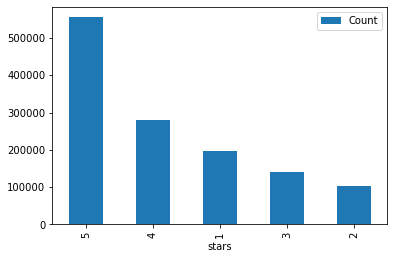

In [65]:
# visualise the results with a barplot, with stars (x-axis) and counts (y-axis)
data.plot.bar(x='stars',y='Count')

In [67]:
# calculate overall average star rating
sum = (data['stars']*data['Count']).sum()
n = data['Count'].sum()
average = sum/n
average

3.702785210277327

The average is about 3.7. We can see that 5 star reviews have the highest frequency, followed by 4 stars and then 1 star. Its possible that people are more likely to write a review in case of a very good or bad experience rather than a normal one. 

#### 1.2 Review count and star distribution among users

- SQL: Write a SELECT statement that counts the reviews and their average star rating grouped by user. Exclude users that joined less than a year before the user that was latest to join as a reviewer (so if e.g. the last user joined on March 28, 2020, exclude all users that joined on March 29, 2019 or later). Hint: use a subquery to do this (you might find this function useful https://dev.mysql.com/doc/refman/8.0/en/date-and-time-functions.html#function_date-add). Users that have never left a review should also be ignored. 
- Python: Execute the SQL query. **Warning!** Due to the size of data, this query can easily take up to 15 minutes to run. Remove users that have left more than 15 reviews. Visualise the review count distribution in a histograms. What pattern(s) do you observe?
- Python: Group the data by count and calculate average and median of stars. Compare median and mean results, and discuss their similarity or difference.

In [68]:
# extract required data
data1 = pd.read_sql_query("SELECT  name, reviews.user_id, COUNT(*), AVG(stars)\
                          FROM reviews, (SELECT user_id,name FROM users\
                          WHERE joined < (SELECT DATE_SUB(max(joined),INTERVAL 1 YEAR) FROM users)) as ss\
                          where reviews.user_id = ss.user_id\
                          GROUP BY user_id", connection)

C:\Users\ASUS\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


<AxesSubplot:ylabel='Frequency'>

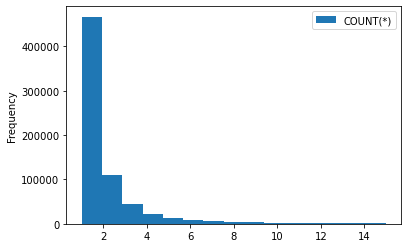

In [69]:
# remove the rows where review counts is > 15
data12 = data1[(data1['COUNT(*)'] <= 15)]
data12.plot.hist(y='COUNT(*)', bins=15)

**Your discussion here:**

In [70]:
count_gb = data12.groupby('COUNT(*)')
count_gb.count()

,name,user_id,AVG(stars)
COUNT(*),,,
1,467082,467082,467082
2,109590,109590,109590
3,44202,44202,44202
4,22428,22428,22428
5,12890,12890,12890
6,8322,8322,8322
7,5657,5657,5657
8,3995,3995,3995
9,3015,3015,3015


#### create a histogram for number of reviews

In [71]:
# calculate mean of average star rating for each count
count_gb.mean()

,AVG(stars)
COUNT(*),
1,3.620842
2,3.726408
3,3.750858
4,3.754526
5,3.755718
6,3.758090
7,3.738529
8,3.778630
9,3.773725


In [72]:
# calculate median of average star rating for each count
count_gb.median()
count_gb.var()

,AVG(stars)
COUNT(*),
1,5.0000
2,4.0000
3,3.6667
4,4.0000
5,3.8000
6,3.8333
7,3.8571
8,3.8750
9,3.7778


,AVG(stars)
COUNT(*),
1,2.756806
2,1.446791
3,1.029612
4,0.812728
5,0.691983
6,0.601138
7,0.550612
8,0.481345
9,0.443266


**Your discussion here:**
We can see that the means are all quite similar, with only the mean for count 1 being somewhat anomalous. This is somewhat surprising when compared to the median. The median for count 1 is 5, which means that at least half of all reviews by users with only 1 review are 5 star reviews. The disparity between the mean and the median suggests that the distribution is quite skewed and has a higher variance compared to the other counts. We indeed see that this is true when we calculate the variance as well.

It could be that users with a small number of reviews, especially with just one review, are those that tend to post reviews only if they are very bad or very good one off experiences, and do not otherwise do so. The users with more reviews clearly ahve more of an interest in reviewing and therefore the ratings might be more balanced.

#### 1.3 Investigate relationship between number of reviews and star rating

- SQL: Write a SELECT statement that returns all of the reviews written by the user as well as the count of reviews they left. Hint: use a window function. Exclude users that joined less than a year before the user that was latest to join as a reviewer. Users that have never left a review should also be ignored. 
- Python: Execute the SQL query. **Warning!** Due to the size of data, this query can easily take up to 15 minutes to run. Visualise the star distribution among users that have left only one review and the ones that have left 10 or more reviews using pie charts. What main differences do you see between the two pie charts? Briefly discuss the results.

In [4]:
# extract the required data
rev_data = pd.read_sql_query("SELECT user_id, stars, COUNT(review_id) OVER(PARTITION BY user_id) AS TotalReviews\
                             FROM reviews WHERE user_id IN (SELECT user_id FROM users WHERE joined < (SELECT DATE_SUB(max(joined), INTERVAL 1 YEAR) FROM users))",
                             connection)

C:\Users\ASUS\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [73]:
# create the two pie charts
one_rev = rev_data[rev_data['TotalReviews'] == 1]
ten_rev = rev_data[rev_data['TotalReviews'] >=10]
one_rev_stars = one_rev['stars']
ten_rev_stars = ten_rev['stars']
one_rev.shape
ten_rev.shape

(467082, 3)

(343507, 3)

<AxesSubplot:ylabel='stars'>

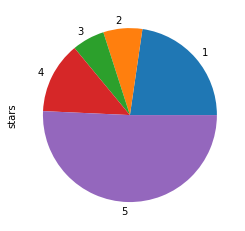

In [74]:
pie10 = ten_rev_stars.groupby(ten_rev_stars)
pie1 = one_rev_stars.groupby(one_rev_stars)
pie1.count().plot(kind='pie', y='stars')

<AxesSubplot:ylabel='stars'>

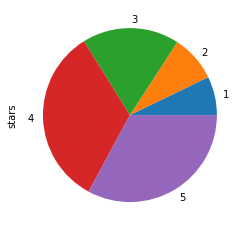

In [75]:
pie10.count().plot(kind='pie', y='stars')

### Problem 2: Business categories (1 point)

You are now asked to provide an overview of businesses and their categories. In particular, we are intersted to see
- the most common business categories,
- the distribution of average star rating per category, and
- if there are any significant differences between categories in terms of start rating.

#### 2.1 Top categories

- SQL: Write a SELECT statement that returns the categories column from the Businesses table. To cut down on the amount of data, randomly sample around 5% of the data in this table. For this sampling, you may find this useful: https://phpfog.com/select-random-sample-records-mysql/. Make sure to remove rows with missing categories values.
- Python: Execute the SQL query. The categories column has a list of categories that each business falls under. Extract every category name from each row list and store it in one big list. Display the 5 most common categories and their counts. Here, you might find these links useful: https://dev.to/courseprobe/iterate-over-rows-in-pandas-3o67; https://www.w3schools.com/python/ref_string_split.asp; https://docs.python.org/3/library/collections.html#collections.Counter.most_common.

In [76]:
# extract the required data
data_b = pd.read_sql_query("SELECT categories FROM businesses\
                            WHERE categories is NOT NULL and RAND()<0.05",
                           connection)

C:\Users\ASUS\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [77]:
# extract separate categories from categories list column
x = 0
categories = []
for i ,r in data_b.iterrows():
    temp = [x.strip() for x in r['categories'].split(",")]
    categories = categories + temp

In [78]:
#give counts of the 5 most common categories
collections.Counter(categories).most_common(5)
#categories

[('Restaurants', 3185),
 ('Shopping', 1743),
 ('Food', 1698),
 ('Home Services', 1184),
 ('Beauty & Spas', 1043)]

#### 2.2 Review differences between top categories

- SQL: Write a SELECT statement that returns an average rating of each business. Create an extra column that returns only one category based on what is contained in the categories column list. The five categories that interest us are (sorted from most to least important): (1) 'Restaurants', (2) 'Shopping', (3) 'Food', (4) 'Home Services', (5) 'Beauty & Spas'. E.g. if the list of the categories column includes the word 'Restaurants' your column should return only 'Restaurants' and ignore any other categories in the list. If, for example, the categories list contains ['Shopping', 'Food', 'Restaurants'] your column should only return 'Restaurants'. You may find the LIKE and CASE WHEN statements useful to carry out the task. Businesses that have less than 5 reviews or do not fall into any category we are interested in should be ignored.
- Python: Execute the SQL query. **Warning!** Due to the size of data, this query can easily take up to 15 minutes to run. Visualise the distribution of average star reviews for each category in seperate plots. Describe what you observe.
- Python: Calculate mean of the average star rating for each category. Perform a Kolmogorov-Smirnov test to see if the distributions of 'Food' and 'Restaurants' category types are significantly different. Here, you might find this useful: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html. Discuss the results.

In [80]:
# extract the required data
category_data = pd.read_sql_query("SELECT reviews.business_id, name , AVG(stars), Category\
                                  FROM reviews, (SELECT name,business_id, CASE \
                                  WHEN categories LIKE '%Restaurants%' THEN 'Restaurant'\
                                  WHEN categories LIKE '%Shopping%' THEN 'Shopping'\
                                  WHEN categories LIKE '%Food%' THEN 'Food'\
                                  WHEN categories LIKE '%Home Services%' THEN 'Home Services'\
                                  WHEN categories LIKE '%Beauty & Spas%' THEN 'Beauty & Spas'\
                                  ELSE NULL END AS Category\
                                  FROM businesses)AS main_cat\
                                  WHERE reviews.business_id = main_cat.business_id AND Category IS NOT NULL \
                                  GROUP BY reviews.business_id\
                                  HAVING COUNT(review_id)>4", connection)

C:\Users\ASUS\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [81]:
# visualise the distribution of average star rating with 5 separate histograms (for each category)
Restaurants = category_data[category_data['Category'] == 'Restaurant']
Shopping = category_data[category_data['Category'] == 'Shopping']
Food = category_data[category_data['Category'] == 'Food']
Home_services = category_data[category_data['Category'] == 'Home Services']
Beauty = category_data[category_data['Category'] == 'Beauty & Spas']

<AxesSubplot:ylabel='Frequency'>

Text(0.5, 1.0, 'Restaurants')

<AxesSubplot:ylabel='Frequency'>

Text(0.5, 1.0, 'Shopping')

<AxesSubplot:ylabel='Frequency'>

Text(0.5, 1.0, 'Food')

<AxesSubplot:ylabel='Frequency'>

Text(0.5, 1.0, 'Home Services')

<AxesSubplot:ylabel='Frequency'>

Text(0.5, 1.0, 'Beauty & Spa')

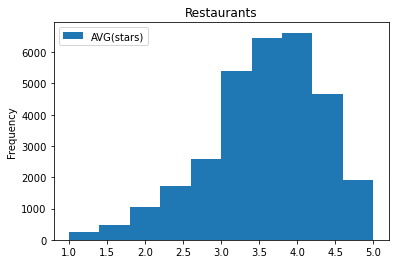

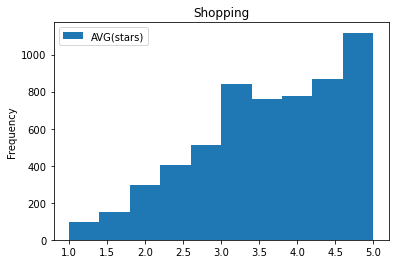

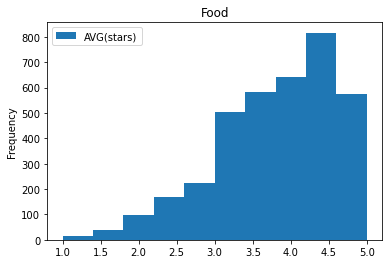

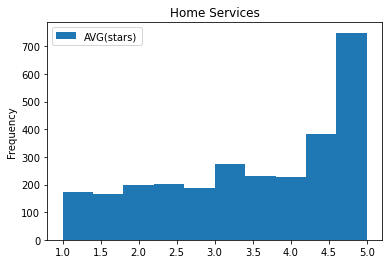

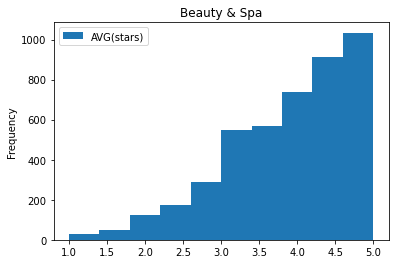

In [82]:
Restaurants.plot.hist(y = 'AVG(stars)')
plt.title("Restaurants")
Shopping.plot.hist(y = 'AVG(stars)')
plt.title("Shopping")
Food.plot.hist(y = 'AVG(stars)')
plt.title("Food")
Home_services.plot.hist(y = 'AVG(stars)')
plt.title("Home Services")
Beauty.plot.hist(y = 'AVG(stars)')
plt.title("Beauty & Spa")

**Your discussion here:**

In [33]:
# calculate the mean of average star rating for each (of the 5) business category
Rmean = Restaurants['AVG(stars)'].mean()
Smean = Shopping['AVG(stars)'].mean()
Fmean = Food['AVG(stars)'].mean()
Hmean = Home_services['AVG(stars)'].mean()
Bmean = Beauty['AVG(stars)'].mean()
means = [Rmean, Smean,Fmean,Hmean,Bmean]
means

[3.5652684737923703,
 3.62394908154506,
 3.8014910704532987,
 3.5107124641833862,
 3.890193012318032]

In [83]:
# perform Kolmogorov-Smirnov test
stats.kstest(Restaurants['AVG(stars)'], Food['AVG(stars)'])

KstestResult(statistic=0.16940860006073322, pvalue=1.0950021125125857e-82)

**Your discussion here:**
Once again, we see that the means of the average star ratings are all similar. That alone doesnt tell us much, however. The histograms of the average ratings look different for each category. Performing the Kolmogorov-Smirnov test confirms that the distributions for Food and Restaurants are different. In the two-sample test, the null hypothesis is that both the samples follow the same distribution, which means that the Alternative hypothesis is that they dont. The calculated p-value is virtuall 0 therefore, we can safley reject the nll hypothesis and comclude that the distribution if the ratings for the two types of businesses are indeed different

### Problem 3: Differences in restaurant star rating across states (2 points)

You have now been asked to investigate if there is any association between the location of the **restaurant** and its star rating. Here, you will perform linear regression using state dummies as regressors, in order to answer this question.

#### 3.1 Investigate which states have the most restaurants

- SQL: Create a (virtual) view called popular_businesses. It should include the ids of businesses that have at least 10 reviews. **Warning!** Carry out this statement in MySQL Workbench, and not via Python. Provide the statement you used below.
- SQL: Write a SQL statement that counts how many restaurants there are in each state. Only include restaurants that appear in the popular_businesses View. Order states by the number of restaurants in descending order.
- Python: Execute the last SQL statement. Identify which states have more than 1,500 restaurants (you will use these states in 3.2).

**Statement to create the view:**

In [84]:
state_data = pd.read_sql_query("SELECT state, COUNT(business_id) AS NumberOfRestaurants\
                                FROM businesses\
                                WHERE business_id IN (SELECT business_id from popular_businesses) AND categories LIKE '%Restaurants%'\
                                GROUP BY state\
                                ORDER BY NumberOfRestaurants DESC", connection)

C:\Users\ASUS\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [86]:
# print which states have more than 1500 restraurants
names = state_data['state'][state_data['NumberOfRestaurants'] >= 1500]
names

0    AZ
1    NV
2    ON
3    NC
4    OH
Name: state, dtype: object

#### 3.2 Create table containing regressors (state dummies) and regressand (star ratings)

- SQL: Write a SQL statement that, for each restaurant, returns its (1) business id, (2) average star review rating, and (3) the state in which the restaurant is situated. Make sure this query only returns data on restaurants that are located in the states with more than 1,500 restaurants that you have identified in 3.1. Moreover, make sure to only include restaurants that have at least 10 reviews.
- Python: Execute the SQL query. Transform the state column into a set of dummy variables, $d_k$ for $k=1,\ldots,K$, where the $k$-th dummy variable equals 1 for observation $i$ if restaurant $i$ is in the state $k$, and 0 for observation $i$ if restaurant $i$ is not located in state $k$. Gather all data in a DataFrame named dummy_data. In this DataFrame make sure the 1st column is the business id, the 2nd column the average star rating of the restaurant, and the remaining columns are the state dummies. Here, you might find this useful: https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html.

In [87]:
# extract the required data
top_states = pd.read_sql_query("SELECT businesses.business_id, AVG(stars), state\
                               FROM popular_businesses JOIN businesses\
                               ON popular_businesses.business_id = businesses.business_id\
                               JOIN reviews\
                               ON reviews.business_id = businesses.business_id\
                               WHERE state IN('AZ','NV','ON','NC', 'OH')\
                               GROUP BY business_id",connection)

C:\Users\ASUS\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [88]:
top_states

,business_id,AVG(stars),state
0,HME5y0qMKFRUbHZykncGNA,2.3592,AZ
1,jyZqmlaziZKtPv8AVTzciw,3.7500,AZ
2,DxzAGrpddzgGmdtNBHgi8g,1.9706,NV
3,fKlr9qNoV37WQJwQ826POg,4.0471,AZ
4,ajoqEHnCZTD8-8GqGLq9-Q,2.8915,NV
...,...,...,...
28809,Pk6YZ0qxl1l94bd3KZ83tQ,2.9000,AZ
28810,lINk_EU_elY6iTrfUGcRqg,2.5000,NV
28811,5lVrzwXAgnbOlczfdWpgJA,4.1000,NC
28812,3Tlvq9GNJ_65wW8xaek40A,4.6000,AZ


In [89]:
# create dummy columns
dummy_data = pd.get_dummies(top_states, columns=['state'])
dummy_data.head()
dummy_data.shape[0]

,business_id,AVG(stars),state_AZ,state_NC,state_NV,state_OH,state_ON
0,HME5y0qMKFRUbHZykncGNA,2.3592,1,0,0,0,0
1,jyZqmlaziZKtPv8AVTzciw,3.7500,1,0,0,0,0
2,DxzAGrpddzgGmdtNBHgi8g,1.9706,0,0,1,0,0
3,fKlr9qNoV37WQJwQ826POg,4.0471,1,0,0,0,0
4,ajoqEHnCZTD8-8GqGLq9-Q,2.8915,0,0,1,0,0


28814

#### 3.3 Perform linear regression

- Python: fill in the code below (...) to correctly perform linear regression on the dummy data frame that you have prepared in 3.2. Compute the $p$-value and discuss the results.

In [91]:
# get regressors and outcome
vY = np.array(dummy_data.iloc[:,1])
mX = np.array(dummy_data.iloc[:,2:]).astype('float64')
# get sample size
iN = dummy_data.shape[0]
# reshape outcome as column vector
vY = np.reshape(vY,(iN,1))
# under H1: regressors are intercept + all dummies except the last
mX = np.hstack((np.ones((iN,1)),mX[:,0:-1]))
# get number of regressors under H1
iK1 = 5
# under H0: just an intercept
iK0 = 1
# compute inv(X'X) and X'y
mInvXTX = np.linalg.inv(mX.transpose() @ mX)
vXTY = mX.transpose() @ vY
# compute OLS estimates as inv(X'X)X'y under H1
vBetaHat = mInvXTX@vXTY
# compute residuals under H1
vResid1 = vY - mX @ vBetaHat
# compute the residuals under H0 by subtracing the mean from the outcome
vResid0 = vY - np.mean(vY)
# compute squared sum of residuals under H0 and H1
dSSR1 = vResid1.transpose() @ vResid1
dSSR0 = vResid0.transpose() @ vResid0
# compute degrees of freedom F-test stat
iDFnum = iK1 - iK0
iDFden = iN - iK1
# compute F-test stat
dF = ((dSSR0 - dSSR1)/iDFnum)/(dSSR1/iDFden)
# use the stats.f.cdf function to compute the P-value
dPval = 1 - stats.f.cdf(dF, iDFnum, iDFden)
# print P-value
print('P-value = ' + str(dPval) + ' for F-test statistic = ' + str(dF) + ' with ' + str(iDFnum) + ' numerator d.o.f. and ' + str(iDFden) + ' denominator d.o.f.')
vBetaHat

P-value = [[1.11022302e-16]] for F-test statistic = [[26.71642457]] with 4 numerator d.o.f. and 28809 denominator d.o.f.


array([[3.56191384],
       [0.10465564],
       [0.09457433],
       [0.14362683],
       [0.14078272]])

**Your discussion here:**
The p-value is very close to 0 and certainly small enough to reject the null hypothesis that the dummy regressors are all 0. The results indicate that even though the estiamted regerssors are small in magnitude, they are indeed significant. This tells us that there are, in fact, small differences in average ratings across states. 

This brings us to the end of Group Assignment 3. Do not forget to save your Jupyter Notebook!